# Gene-gene and gene-reaction clustermaps

In [1]:
#import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#import self-made functions
%run '/Users/mariekececilia/Documents/master_thesis_code/methods.ipynb'

In [3]:
#figure saving settings for this Notebook
figure_folder_path = 'Figures/'
figure_format = 'png'

## Load and clean data

Load data, split ishii into growth rate and knock-out set (both containing the baseline WT at 0.2h-'):

In [4]:
gexp_g, flux_g = load_gerosa()
gexp_i, flux_i = load_ishii()
gexp_i_gr, gexp_i_ko = split_ishii(gexp_i)
flux_i_gr, flux_i_ko = split_ishii(flux_i) 

Clean the data:

In [5]:
#remove duplicated genes, only relevant for gerosa:
gexp_g, _ = clean_gexp_g(gexp_g)

#remove constant, duplicated, and external reactions + reactions with many null entries: 
flux_g, _ = clean_gerosa(flux_g)
flux_i_gr, _ = clean_ishii(flux_i_gr)
flux_i_ko, _ = clean_ishii(flux_i_ko)

## Prepare data for analysis

In [6]:
#Calculate absolute fluxes because amount of required enzyme is independent of flux direction 
flux_g = flux_g.abs()
flux_i_gr = flux_i_gr.abs()
flux_i_ko = flux_i_ko.abs()

#remove R_ from reaction name to make nicer labels:
flux_g.columns = flux_g.columns.str.replace('R_', '')
flux_i_gr.columns = flux_i_gr.columns.str.replace('R_', '')
flux_i_ko.columns = flux_i_ko.columns.str.replace('R_', '')

## Calculate Spearman's rank correlations

In [7]:
#merge genes and reactions, and calculate all pairwise spearman correlations 
corr_g = pd.concat([gexp_g, flux_g], axis=1).corr(method = 'spearman')
corr_i_gr = pd.concat([gexp_i_gr, flux_i_gr], axis=1).corr(method = 'spearman')
corr_i_ko = pd.concat([gexp_i_ko, flux_i_ko], axis=1).corr(method = 'spearman')

#split result into sub-matrices of only gene-gene or gene-reaction correlations
#matrices to split
corr_all = [corr_g, 
            corr_i_gr, 
            corr_i_ko]
#respective gene columns to extract
columns_g = [gexp_g.columns,
             gexp_i_gr.columns,
             gexp_i_ko.columns]
#respective reaction columns to extract
columns_f = [flux_g.columns,
             flux_i_gr.columns,
             flux_i_ko.columns]
#extract and store the sub-matrcies
corr_gg = []
corr_gf = []
for g, f, corr in zip(columns_g, columns_f, corr_all):
    #genes vs genes:
    gg = corr.loc[g,g]
    corr_gg.append(gg)
    #genes vs reactions:
    gf = corr.loc[g,f]
    corr_gf.append(gf)

## Draw clustermaps

In [8]:
#lists of metadata matching the elements in corr_gg and corr_gf
names = ['gerosa',
         'ishii_gr',
         'Ishii_ko']
datasets = ['Gerosa',
          'Ishii GR',
          'Ishii KO']

/Users/mariekececilia/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


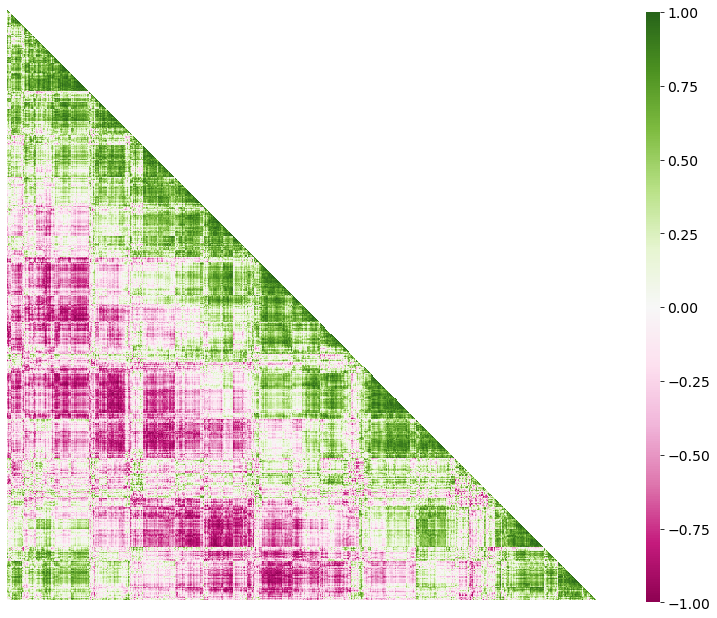

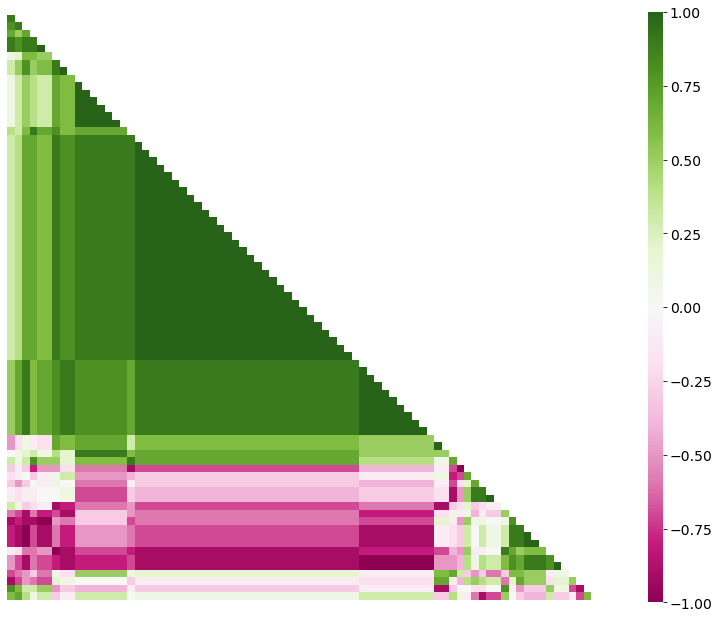

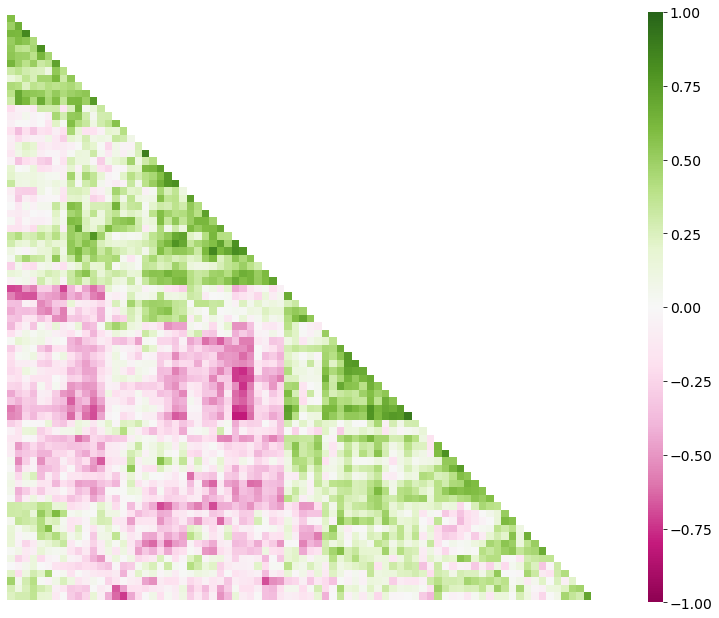

In [9]:
#gene-gene clustermaps
for corr, name, dataset in zip(corr_gg, names, datasets):
    
    #figure name and title
    figure_name = 'clustermap_' + name + '_gg'
    suptitle = 'Gene-gene correlations in' + dataset
    
    #draw figure
    g = sns.clustermap(data = corr,
                       figsize = (10,10),
                       dendrogram_ratio=0.1,
                       cmap = 'PiYG',
                       cbar_pos = (1, 0.065, 0.02, 0.82), #left, bottom, width, height
                       vmin = -1,
                       vmax = 1,
                      )
    g.ax_heatmap.tick_params(labelbottom=False, labelright = False, right=False, bottom=False) #remove ticks because too many
    g.figure.axes[-1].tick_params(labelsize=14) #increase color bar font size
    #remove triangle
    #mask = np.tril(np.ones_like(corr)) #lower removed
    mask = np.triu(np.ones_like(corr)) #upper removed
    values = g.ax_heatmap.collections[0].get_array().reshape(corr.shape)
    new_values = np.ma.array(values, mask=mask)
    g.ax_heatmap.collections[0].set_array(new_values)
    #remove dendograms
    g.ax_col_dendrogram.set_visible(False)
    g.ax_row_dendrogram.set_visible(False) 

    #g.fig.suptitle(suptitle, fontweight='bold', y = 0.85)

        
    #save figure
    g.savefig(('%s%s.%s' % (figure_folder_path, figure_name, figure_format)), 
              format=figure_format, 
              dpi=200,
              facecolor = 'white',
             )
    plt.show()
    plt.close()

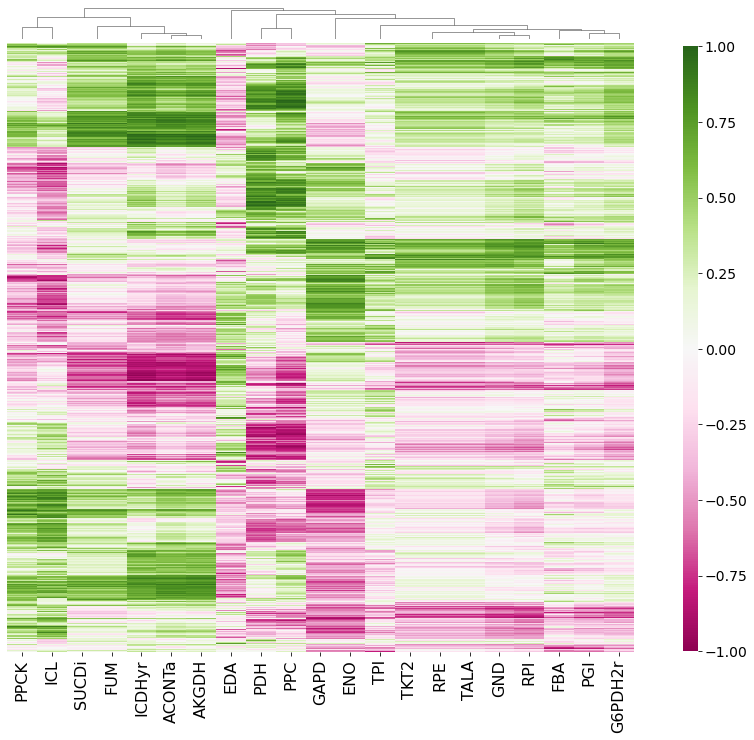

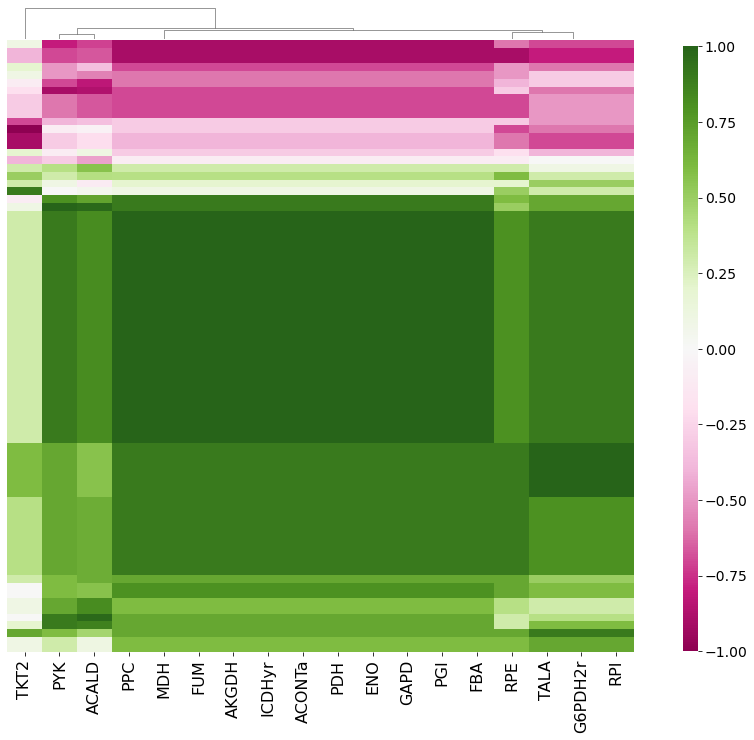

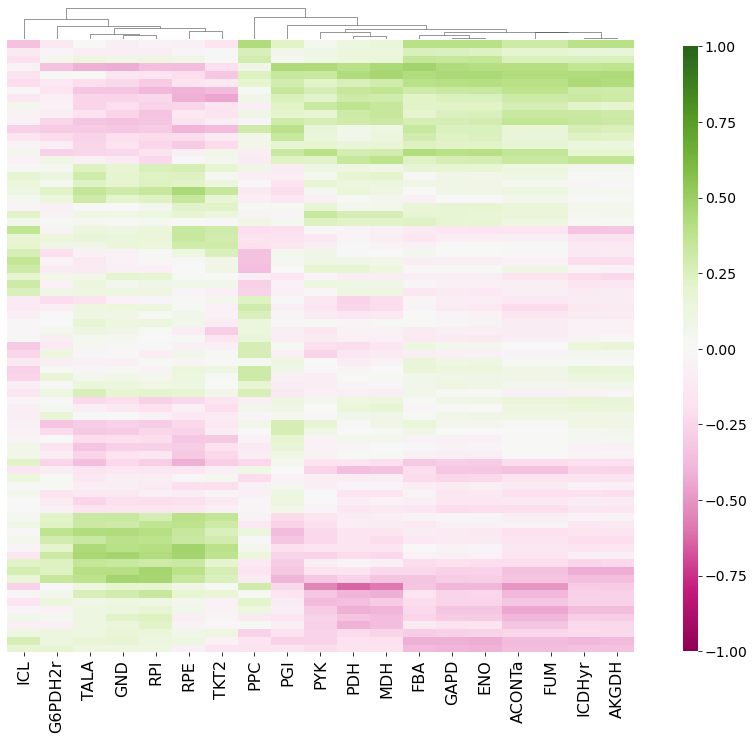

In [10]:
#gene-reaction clustermaps
for corr, name, dataset in zip(corr_gf, names, datasets):
    
    #figure name and title
    figure_name = 'clustermap_' + name + '_gf'
    suptitle =  'Gene-reaction correlations in ' + dataset
    
    #draw figure
    g = sns.clustermap(data = corr,
                      figsize = (10,10),
                      dendrogram_ratio=0.05,
                      cmap = 'PiYG',
                      cbar_pos = (1, 0.09, 0.02, 0.84), #left, bottom, width, height
                      vmin = -1,
                      vmax = 1,
                     )
    g.ax_heatmap.tick_params(bottom=True, labelbottom=True, labelright = False, right=False) #remove gene ticks because too many
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 16) #increase tick label size
    g.figure.axes[-1].tick_params(labelsize=14) #increase color bar font
    g.ax_row_dendrogram.set_visible(False) 
    #g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 16) #increase tick label size
    #g.ax_col_dendrogram.set_visible(False)
    #g.fig.suptitle(suptitle, y = 1.05, fontweight='bold')

    #save figure
    g.savefig(('%s%s.%s' % (figure_folder_path, figure_name, figure_format)), 
              format=figure_format, 
              dpi=200,
              facecolor = 'white',
              bbox_inches = 'tight', #include the legend 
             )
    plt.show()
    plt.close()